### Libraries

In [ ]:
import os
import sys

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# (Optional) If you're working inside Jupyter
%load_ext autoreload
%autoreload 2
%matplotlib inline



In [ ]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():  # Apple Silicon GPU
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")



In [ ]:
from data_processor_v2 import DataProcessorUpdated

processor = DataProcessorUpdated()

In [ ]:
processor.load_and_clean_data()

In [ ]:
%env CUDA_VISIBLE_DEVICES=4,5


In [ ]:
!echo $CUDA_VISIBLE_DEVICES

In [ ]:
processor.combine_all_data()

In [ ]:
processor.df

In [ ]:
processor.shift_dap()

In [ ]:
processor.df

In [ ]:
processor.split_data(feature_columns=['DAP_SystemLambda', 'SCED_system_lambda','Fuel_solar','Fuel_wind','Load_load'])

In [ ]:
processor.standardize_data()

In [ ]:
processor.shift_data()

In [ ]:
df, x_train_lstm, y_train_lstm, x_val_lstm, y_val_lstm, x_test_lstm, y_test_lstm = processor.get_data()

In [ ]:
x_train_lstm.shape

In [ ]:
y_val_lstm = y_val_lstm.squeeze(-1)
y_test_lstm = y_test_lstm.squeeze(-1)
y_train_lstm = y_train_lstm.squeeze(-1)


In [ ]:
print("x_train:", x_train_lstm.shape)   # 期望 (N, 32, 2) 或 (N, 24, 2)
print("y_train:", y_train_lstm.shape)   # 期望 (N, 32)   或 (N, 24)


# Model Building

In [25]:
import torch
from CNN import CNN2D_Model   # 根据你的文件结构保持不变

# 1. 选择设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. 实例化模型（符合新签名）
cnn_mlp = CNN2D_Model(
    n_features=5,            # 输入特征数
    horizon=24,              # 预测步长
    cnn_channels=32,         # 卷积通道
).to(device)

from ModelTrainer import ModelTrainer
from losses import fluctuation_loss  # or define it above in your notebook

trainer = ModelTrainer(
    model=cnn_mlp,
    features_training_data=x_train_lstm,
    target_training_data=y_train_lstm,
    features_eval_data=x_val_lstm,
    target_eval_data=y_val_lstm,
    device=device,
    loss_fn=lambda pred, target: fluctuation_loss(pred, target, alpha=0.2)
)

trainer.train(epochs=100, batch_size=32, patience=50, learning_rate=1.5193139573153885e-05)

Epoch 5: Train Loss = 1.0178, Eval Loss = 0.2671
Epoch 6: Train Loss = 1.0142, Eval Loss = 0.2678
Epoch 7: Train Loss = 1.0113, Eval Loss = 0.2675
Epoch 8: Train Loss = 1.0082, Eval Loss = 0.2674
Epoch 9: Train Loss = 1.0054, Eval Loss = 0.2670
Epoch 10: Train Loss = 1.0027, Eval Loss = 0.2649
Epoch 11: Train Loss = 1.0003, Eval Loss = 0.2686
Epoch 12: Train Loss = 0.9976, Eval Loss = 0.2659
Epoch 13: Train Loss = 0.9950, Eval Loss = 0.2651
Epoch 14: Train Loss = 0.9924, Eval Loss = 0.2665
Epoch 15: Train Loss = 0.9899, Eval Loss = 0.2665
Epoch 16: Train Loss = 0.9873, Eval Loss = 0.2656
Epoch 17: Train Loss = 0.9850, Eval Loss = 0.2683
Epoch 18: Train Loss = 0.9824, Eval Loss = 0.2661
Epoch 19: Train Loss = 0.9798, Eval Loss = 0.2679
Epoch 20: Train Loss = 0.9780, Eval Loss = 0.2684
Epoch 21: Train Loss = 0.9754, Eval Loss = 0.2681
Epoch 22: Train Loss = 0.9729, Eval Loss = 0.2678
Epoch 23: Train Loss = 0.9709, Eval Loss = 0.2691
Epoch 24: Train Loss = 0.9682, Eval Loss = 0.2678
Epoch

In [27]:
loss = trainer.history['eval_loss']

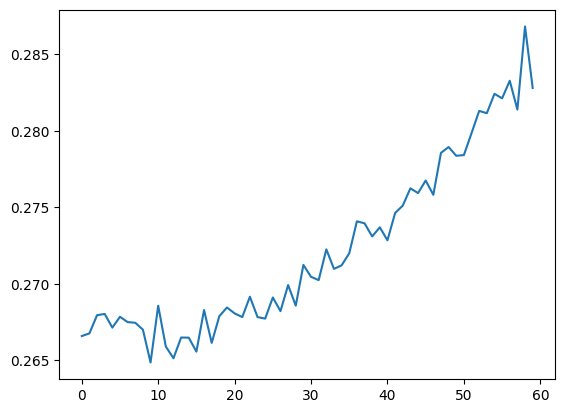

In [28]:
import matplotlib.pyplot as plt

plt.plot(loss)

In [ ]:
import optuna
import torch
from CNN import CNN2D_Model
from ModelTrainer import ModelTrainer
from losses import fluctuation_loss



# ------------- 设备 -------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------- Optuna 目标函数 -------------------
def objective(trial):
    # ---- 超参数搜索空间 ----
    cnn_channels = trial.suggest_categorical("cnn_channels", [32, 64, 128])
    # hidden_dim   = trial.suggest_categorical("mlp_hidden_dim", [128, 256, 512])
    # n_layers     = trial.suggest_int("n_layers", 2, 4)
    lr           = trial.suggest_loguniform("lr", 1e-5, 1e-3)
    alpha        = trial.suggest_uniform("alpha", 0.1, 0.5)

    # hidden_dims = [hidden_dim] * n_layers   # MLP 隐层列表

    # ---- 构建模型 ----
    cnn_mlp = CNN2D_Model(
        n_features=5,            # 输入特征数
        horizon=24,              # 预测步长
        cnn_channels=cnn_channels,         # 卷积通道
    ).to(device)

    # ---- 训练器 ----
    trainer = ModelTrainer(
        model=cnn_mlp,
        features_training_data=x_train_lstm,
        target_training_data=y_train_lstm,
        features_eval_data=x_val_lstm,
        target_eval_data=y_val_lstm,
        device=device,
        loss_fn=lambda pred, target: fluctuation_loss(pred, target, alpha=alpha)
    )

    # ---- 训练，控制轮数别太大避免单次 trial 过慢 ----
    trainer.train(epochs=50, batch_size=32, patience=10, learning_rate=lr)

    # ---- 返回验证集最后一次 (或最优) 损失 ----
    return trainer.history['eval_loss'][-1]

# ------------- 创建并运行 Optuna Study -------------------
study = optuna.create_study(direction="minimize",
                            pruner=optuna.pruners.HyperbandPruner())
study.optimize(objective, n_trials=50)

print("最佳 trial:", study.best_trial.params)
print("最佳 eval_loss:", study.best_value)


In [ ]:

study = optuna.create_study(
    direction="minimize",
    pruner=optuna.pruners.HyperbandPruner()
)
study.optimize(objective, n_trials=50)


In [ ]:
print("Best hyperparameters:", study.best_trial.params)


In [ ]:
# predict

mlp_model.eval()
with torch.no_grad():
    y_pred = mlp_model(torch.tensor(x_test_mlp, dtype=torch.float32).to(device))


y_pred = y_pred.cpu().numpy()
errors = y_pred - y_test_mlp  # assuming y_test is numpy array
mse = np.mean(errors**2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(errors))

print(f"Test MAE: {mae:.4f}")
print(f"Test RMSE: {rmse:.4f}")

